In [1]:
import sys
sys.path.append('../popalign/')
import popalign as PA
import importlib

In [2]:
PA.__file__

'../popalign/popalign.py'

In [3]:
# Load data (example)
LOAD = 'screen'

if LOAD == 'samples':
    mysamples = {
        'CTRL' : '../data/samples/PBMC.mtx',
        'GMCSF_1ng/ml' : '../data/samples/GMCSF.mtx',
        'IFNG_1ng/ml' : '../data/samples/IFNG.mtx',
        'IL2_10ng/ml' : '../data/samples/IL2.mtx',
        'CD40L_20ng/ml' : '../data/samples/CD40L.mtx',
    }
    mygenes = '../data/samples/genes.tsv'
    pop = PA.load_samples(samples=mysamples, 
                          genes=mygenes)
    
elif LOAD == 'screen':
    mymatrix = '../data/screen/drug_screen/pbmcmult4cd3minus.mtx'
    mybarcodes = '../data/screen/drug_screen/barcodes.tsv'
    mygenes = '../data/screen/drug_screen/features.tsv'
    mymetadata = '../data/screen/drug_screen/meta.csv'
    pop = PA.load_screen(matrix=mymatrix, 
                         barcodes=mybarcodes, 
                         metafile=mymetadata, 
                         genes=mygenes)

In [4]:
# Perform column normalization
# Find best normalization factor
PA.normalize(pop)

Performing column normalization
Finding best normalization factor


2666 genes selected


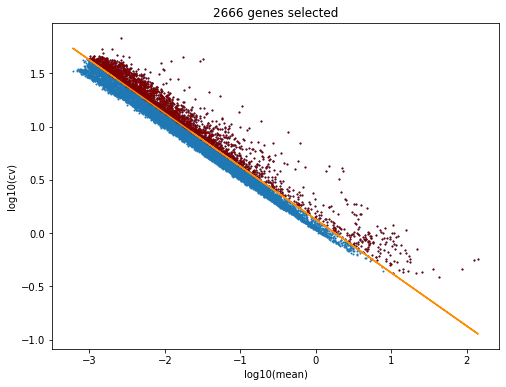

In [5]:
# Plot genes (log cv ~ log cv) and filtering line --use multiple times to find best offset (usually between .7 and 1.5)
PA.plot_gene_filter(pop, offset=1.1)

In [6]:
# Gene filter the data with the last offset value used in the previous step
PA.filter(pop)

Removing ribosomal genes
Filtering genes ang logging data


In [7]:
# Remove red blood cells from the data
PA.removeRBC(pop, 'human')

Meprednisone 943 cells kept out of 943
Dexrazoxane HCl (ICRF-187, ADR-529) 720 cells kept out of 720
Etodolac 898 cells kept out of 898
Phenylbutazone 671 cells kept out of 671
Pomalidomide 804 cells kept out of 804
Budesonide 726 cells kept out of 726
Loteprednol etabonate 646 cells kept out of 646
CTRL 3584 cells kept out of 3585
Betamethasone Valerate 1004 cells kept out of 1004
Febuxostat 848 cells kept out of 848
Sulfasalazine 796 cells kept out of 796
Flurbiprofen 834 cells kept out of 834
Mianserin HCl 744 cells kept out of 744
Naproxen Sodium 670 cells kept out of 670
Triamcinolone Acetonide 866 cells kept out of 866
Acetylcysteine 903 cells kept out of 903
Everolimus (RAD001) 486 cells kept out of 486
Isotretinoin 927 cells kept out of 927
Ibuprofen 893 cells kept out of 893
Doramapimod (BIRB 796) 908 cells kept out of 908
Allopurinol Sodium 666 cells kept out of 666
Tranilast 1081 cells kept out of 1081
Cyclosporine 738 cells kept out of 738
Adapalene 806 cells kept out of 80

In [8]:
# Generate multiple feature spaces and pick the best one based on reconstruction error
# Run GSEA on each feature
# Generate QC plots
PA.onmf(pop, ncells=5000, nfeats=[5,7], nreps=3, niter=300)

Computing W matrices
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #299
......... Iteration #299
......... Iteration #299
Orthogonal NMF performed with 300 iterations

Orthogonal NMF performed with 300 iterations

Orthogonal NMF performed with 300 iterations

......... Iteration #299
......... Iteration #299
Orthogonal NMF performed with 300 iterations

......... Iteration #299
Orthogonal NMF performed with 300 iterations

Orthogonal NMF performed with 300 iterations

Computing reconstruction errors
Progress: 1 of 6
Progress: 2 of 6
Progress: 3 of 6
Progress: 4 of 6
Progress: 5 of 

In [ ]:
# Build a Gaussian Mixture model for each sample
# Type the models subpopulations
importlib.reload(PA) 
PA.build_gmms(pop, 
              ks=(5,20), 
              niters=3, 
              training=800, 
              nreplicates=10, 
              reg_covar=True, 
              rendering='grouped', 
              types=None)

In [ ]:
# Calculate all the subpopulations entropies for each samples
PA.entropy(pop)

In [ ]:
# Align subpopulations of each sample against a reference model's subpopulations
importlib.reload(PA)
PA.align(pop, ref='CTRL', method='conservative')

In [ ]:
# Rank each sample against a reference sample's model
PA.rank(pop, ref='CTRL', k=100, niter=200, mincells=50)

In [9]:
# Build a unique GMM for the samples concatenated together
importlib.reload(PA)
PA.build_unique_gmm(pop, ks=(5,20), niters=3, reg_covar=True, types=None)

In [14]:
# Generate a query plot
importlib.reload(PA)
PA.plot_query(pop)
PA.plot_query_heatmap(pop)

Plot saved under output/query/query_plot.pdf
Plot saved under output/query/query_heatmap.pdf


In [ ]:
# Interactive 3D visualization of the data in feature space
import plotly
plotly.offline.init_notebook_mode()
PA.plotfeatures(pop)